In [1]:
import numpy as np
import matplotlib.pyplot as plt
from noise_generator import GenerateNoise
import qutip as qt
from hamiltonian_generator import Hamiltonian

In [2]:
sample_rate = 1               # per ns
tnoise_max = int(1e5)             # number of samples
omega_ir = 1/tnoise_max*2*np.pi
S0 = 1e-2
relative_PSD_strength = S0**2
num_realizations = 1000
ifwhite = False               # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = tnoise_max * sample_rate
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
trajs = gn.generate_colored_noise()
S0 = gn.analyze_noise_psd(trajs)

In [3]:
trajs = gn.generate_colored_noise()

Sanity Checks (1/f noise):
PSD fit: power = -1.0000, intercept = -4.5598, R² = 0.9990, S0 = 2.094052e-03


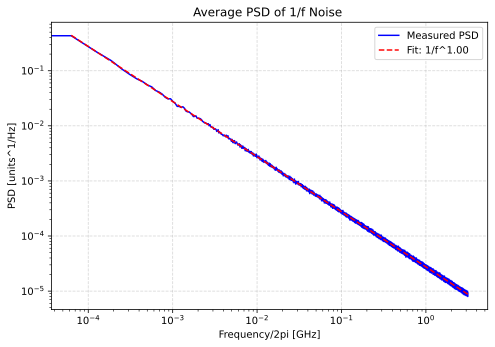

In [4]:
S0 = gn.analyze_noise_psd(trajs)

In [5]:
phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [4,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A,optimal_omega)
noise = sc.noise
# (np.cos(phi_ex*np.pi)*(np.cos(trajectory*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajectory*np.pi))



: 

In [ ]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
all_expect_values = []
t_max = 300
N = t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory
initial_state = qt.Qobj(initial_state)
noise = qt.Qobj(noise)


# Loop through each noise trajectory
for i in range(num_realizations):
    # Create time-dependent Hamiltonian with noise
    H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)], [noise, lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = sesolve(H, initial_state, time_points)
    # Calculate projector averages for each time point
    avg_values = np.zeros((2, len(time_points)))
    for j, t in enumerate(time_points):
        # Get the state at time t
        state_t = result.states[j]
        
        # Get the projector at time t
        U, _ = state_and_sigmax(t)
        projectors = get_projector(U)
        
        # Calculate expectation values for both projectors
        avg_values[0, j] = qt.expect(projectors[0], state_t)
        avg_values[1, j] = qt.expect(projectors[1], state_t)
    
    # Store the expectation values for both projectors
    all_expect_values.append(avg_values)

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/integrator/scipy_integrator.py", line 69, in _mul_np_vec
    out = self.system.matmul_data(t, state)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


Quantum object: dims=[[12], [12]], shape=(12, 12), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-5.30936513e-03 -3.15883863e-20 -1.02862834e-16 -1.34800553e-20
   7.25297372e-16 -1.37741659e-20 -2.23550630e-16  1.97492605e-21
   3.16957611e-17  2.45879226e-22  2.58732566e-17  8.08635428e-23]
 [-3.15883863e-20  3.27606454e+01 -3.87816579e-15  1.99840144e-14
  -2.22658078e-16  1.03250741e-14 -6.04171436e-15  2.60555466e-14
  -4.98901503e-16 -7.72125419e-15  3.36009857e-15 -6.04681236e-15]
 [-1.11022302e-16 -3.87816579e-15  6.55265418e+01  3.63343762e-15
  -2.13162821e-14  2.17686803e-15 -4.50750548e-14 -5.91292262e-16
   4.54081217e-14 -6.49511460e-17 -2.92266211e-14 -3.68771502e-17]
 [-1.34800553e-20  2.10942375e-14  3.63343762e-15  3.86933874e+01
   2.05072311e-15  1.19904087e-14  6.50301051e-15 -1.45994328e-14
  -4.91784507e-15 -8.86790641e-15 -1.48738146e-15 -8.77509870e-15]
 [ 6.66133815e-16 -2.22658078e-16 -2.13162821e-14  2.05072311e-15
   7.14460323e+01  1.30545026e-15 -1.